# Домашняя работа 7

## Подготовка

Импортируем библиотеки, задаемм random state и прописываем путь к папке артефактов

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
)
import json
from pathlib import Path

RANDOM_STATE=42
np.random.seed(RANDOM_STATE)

artifacts_path = Path("artifacts")
artifacts_path.mkdir(parents=True,exist_ok=True)


Задаем конфиг настроек 

In [110]:
pca_dim = None

kmeans_ks = list(range(2,21))

dbscan_eps = [1.5,2.0,2.5,3.0,3.5]
dbscan_min_samples = [3,5,10]

print("Config:")
print(" pca_dim:", pca_dim)
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)


Config:
 pca_dim: None
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.5, 2.0, 2.5, 3.0, 3.5]
 dbscan min_samples: [3, 5, 10]


Создаем функцию полного препроцессинга данных

In [111]:
def Preprocessing(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Числовых признаков: {len(numeric_features)}")
    print(f"Категориальных признаков: {len(categorical_features)}")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    X_feat = preprocessor.fit_transform(X)

    print("X_feat.shape:", X_feat.shape)
    return X_feat

Создаем функции для подсчета метрик, и для графиков pca2d

In [112]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)

    if len(unique) < 2:
        return None

    if len(unique) == 1:
        return None

    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title,filename:str):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.savefig(artifacts_path / "figures" / filename)
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


Создаем функцию для обучения модели KMeans, и отдельную для выбора лучшего результата по метрике

In [113]:
def eval_kmeans_grid(X_feat,ks,dataset:str):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k,random_state=RANDOM_STATE,n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k,random_state=RANDOM_STATE,n_init=10)
        
        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat,labels)
        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    
    ks = [r["params"]["k"] for r in results]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in results]

    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    if dataset!=None:
        plt.savefig(artifacts_path / "figures" / f"{dataset}_kmeans_sil_vs_k_plot.png")
    plt.show()

    inertia = [r["inertia"] for r in results]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title("KMeans: inertia vs k (elbow heuristic)")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    plt.show()


    return results

def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

Создаем аналогичную функцию для модели DBSCAN

In [114]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))

            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })

    valid = [r for r in results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
    print("Valid DBSCAN configs:", len(valid))

    # Сортировка по silhouette
    valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
    for r in valid_sorted[:8]:
        print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


    best_dbscan = valid_sorted[0] if valid_sorted else None
    print(best_dbscan["params"] if best_dbscan else "No valid config found")
    
    return results,best_dbscan




Создаем функции для вывода карты результатов

In [115]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

def print_result_card_by_best(best_kmeans,best_dbscan):
    print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
    if best_dbscan is not None:
        print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)

И создаем функцию для создания графиков 

In [116]:
def X_plot_2d(X_feat,best_kmeans,best_dbscan,dataset:str):
    X_plot2d = pca_2d_for_plot(X_feat, random_state=RANDOM_STATE)

    # KMeans best
    plot_2d_embedding(
        X_plot2d, best_kmeans["labels"],
        title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}",
        filename=f"{dataset}_pca2d_plot_best_kmeans_by_silhoutte.png"
    )

    # DBSCAN best (if exists)
    if best_dbscan is not None:
        plot_2d_embedding(
            X_plot2d, best_dbscan["labels"],
            title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)",
            filename=f"{dataset}_pca2d_plot_best_dbscan_by_silhoutte.png"
        )

А также создадим функцию чтобы интерпретировать кластеры

In [117]:
def cluster_interpretation(X_feat,label,best_result):
    labels = label['cluster_label'].values
    n_clusters = best_result["n_clusters"]

    print("\nРазмеры кластеров:")
    cluster_counts = label['cluster_label'].value_counts().sort_index()
    for cluster_id, size in cluster_counts.items():
        print(f"Кластер {cluster_id}: {size} объектов ({size/len(label):.1%})")

    print("\nХарактерные признаки по кластерам:")
    for cluster_id in range(n_clusters):
        # Получаем индексы объектов этого кластера
        cluster_mask = labels == cluster_id
        
        # Проверяем, что кластер не пустой
        if cluster_mask.sum() == 0:
            print(f"Кластер {cluster_id}: пустой")
            continue
        
        # Выбираем соответствующие строки из X_feat
        cluster_data = X_feat[cluster_mask]
        
        z_scores = (cluster_data.mean(axis=0) - X_feat.mean(axis=0)) / X_feat.std(axis=0)
        
        abs_z = np.abs(z_scores)
        top_indices = np.argsort(-abs_z)[:3]
        
        # Выводим с направлением отклонения
        feature_desc = []
        for idx in top_indices:
            feat_name = f"f{idx:02d}"  # или ваши альтернативные названия признаков
            direction = "↑" if z_scores[idx] > 0 else "↓"
            feature_desc.append(f"{feat_name}{direction}({z_scores[idx]:.1f})")
        
        print(f"Кластер {cluster_id}: {', '.join(feature_desc)}")

## Подготовка к сохранению артефактов

Теперь подготовимся к сохранению нужных данных артефактов - создаем две функции для создания словарей с нужными результатами 

In [118]:
def create_metrics_summary(kmean_results_dict, dbscan_results_dict):
    summary = {}

    if kmean_results_dict:
        summary['KMeans'] = kmean_results_dict["metrics"]
    if dbscan_results_dict:
        summary["DBSCAN"] = dbscan_results_dict["metrics"]
        summary["DBSCAN"]["noise_frac"] = dbscan_results_dict["noise_frac"]
        summary["DBSCAN"]["n_non_noise"] = dbscan_results_dict["n_non_noise"]
    
    return summary

def create_best_configs(best_model_results_dict):
    summary = {}

    if best_model_results_dict:
        summary["algo"]= best_model_results_dict["algo"]
        summary["params"] = best_model_results_dict["params"]
        summary["criteria"] = "metrics"

    
    return summary

Функция для сохранения dict в json

In [119]:
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

И вводим глобальные переменные словарей для сохранения результатов

In [120]:
metrics_summary = {}
best_configs = {}

## Dataset 01

Импортируем первый датасет и выводим все базовые статистики

In [121]:
dataset_01 = pd.read_csv("data/S07-hw-dataset-01.csv")

dataset_01.head(5)
    

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [122]:
print(dataset_01.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
None


In [123]:
print(dataset_01.describe())

         sample_id           f01           f02           f03           f04  \
count  12000.00000  12000.000000  12000.000000  12000.000000  12000.000000   
mean    5999.50000     -2.424716     19.107804     -0.222063     -8.284501   
std     3464.24595     11.014315     60.790338      0.500630     59.269838   
min        0.00000    -19.912573    -92.892652     -1.590979   -134.303679   
25%     2999.75000     -9.472623    -40.282955     -0.125145    -48.345007   
50%     5999.50000     -6.869404     54.069335     -0.031753     16.211728   
75%     8999.25000      0.523841     70.280739      0.054980     28.067178   
max    11999.00000     24.403381    112.229523      0.512277     75.088604   

                f05           f06           f07           f08  
count  12000.000000  12000.000000  12000.000000  12000.000000  
mean      -0.190717      0.962972      0.033724      0.007638  
std        7.026435     14.794713     59.541782      0.607053  
min      -11.869169    -20.521164   -215.

Выделяем X, сохраняем отдельно sample_id 

In [124]:
X = dataset_01.drop("sample_id",axis=1)
sample_id = dataset_01["sample_id"]

print("X.shape:", X.shape)

X.shape: (12000, 8)


Делаем препроцессинг данных

In [125]:
X_feat = Preprocessing(X)

Числовых признаков: 8
Категориальных признаков: 0
X_feat.shape: (12000, 8)


Теперь обучаем модель KMeans

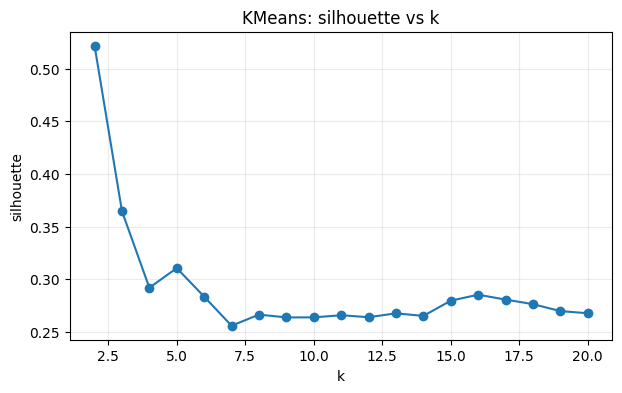

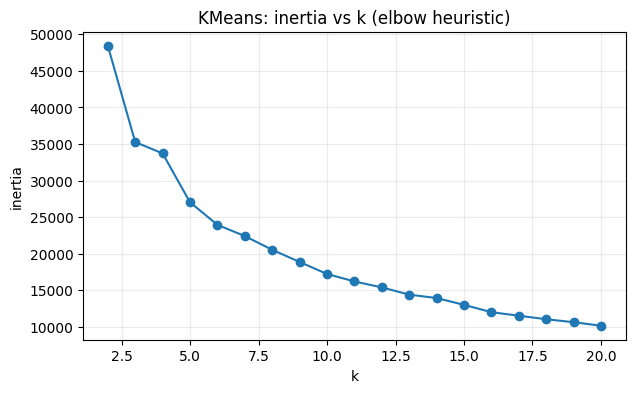

(19, {'k': 2}, {'k': 20})

In [126]:
kmeans_results = eval_kmeans_grid(X_feat,kmeans_ks,"ds01")
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

Выбираем лучшую модель kmeans

In [127]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)

({'k': 2}, 0.522)

Теперь аналогичные действия, только модель DBSCAN

In [128]:
dbscan_results,best_dbscan = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

Valid DBSCAN configs: 9
{'eps': 2.0, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 1.5, 'min_samples': 3} sil= 0.397 noise= 0.0 clusters= 3
{'eps': 1.5, 'min_samples': 5} sil= 0.397 noise= 0.0 clusters= 3
{'eps': 2.0, 'min_samples': 3}


15

Выводим карточки результатов

In [129]:
print_result_card_by_best(best_kmeans,best_dbscan)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 3}
n_clusters: 2
noise_frac: 0.0  non-noise: 12000
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0


Выводим графики

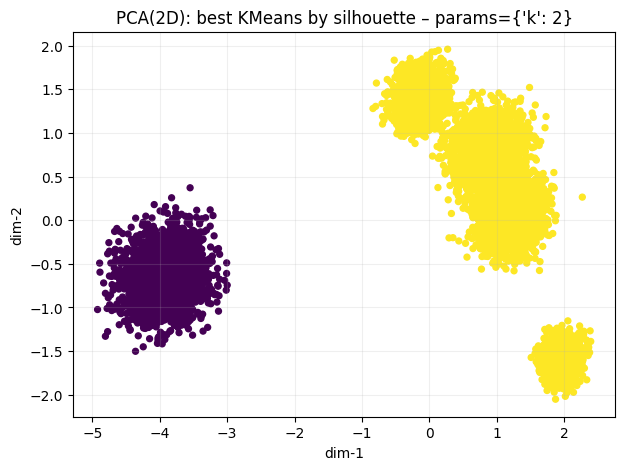

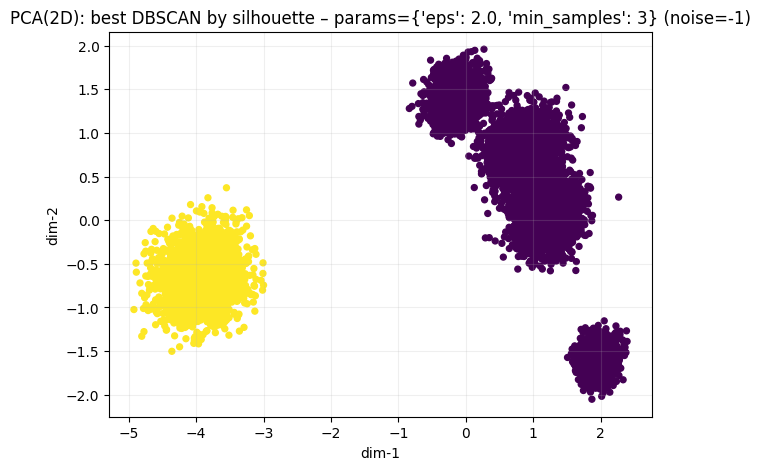

In [130]:
X_plot_2d(X_feat,best_kmeans,best_dbscan,"ds01")

Сохраняем метрики 

In [131]:
metrics_summary["dataset_01"] = create_metrics_summary(best_kmeans,best_dbscan)

Вывод:
По полученным метрикам могу сделать вывод, что с данным набором данных не важно какую модель использовать - метрики абсолютно одинаковые (но лучшей выберу KMeans из-за большей простоты)

По результатам с этими данными получились четкие два кластера, при обоих алгоритмах. Сложности с данными не возникло - выбросов нет, данные полностью числовые, пропуски отсутствуют. KMeans уместен из-за сферической формы кластеров, DBSCAN - для проверки шума и произвольной формы.

Сохраняем конфиг лучшей модели и сохраняем label в файл

In [132]:
best_configs["best_config_ds01"] = create_best_configs(best_kmeans)

In [133]:
label = pd.DataFrame()
label["sample_id"] = sample_id
label["cluster_label"] = best_kmeans["labels"]
label.to_csv(artifacts_path/"labels"/ 'labels_hw07_ds1.csv', index=False)

Интерпретируем кластеры

In [134]:
cluster_interpretation(X_feat,label,best_kmeans)


Размеры кластеров:
Кластер 0: 2400 объектов (20.0%)
Кластер 1: 9600 объектов (80.0%)

Характерные признаки по кластерам:
Кластер 0: f02↓(-1.9), f05↑(1.9), f00↑(1.8)
Кластер 1: f02↑(0.5), f05↓(-0.5), f00↓(-0.5)


### Проверка устойчивости

Перебираем random_states и обучаем модели сохраняя результаты

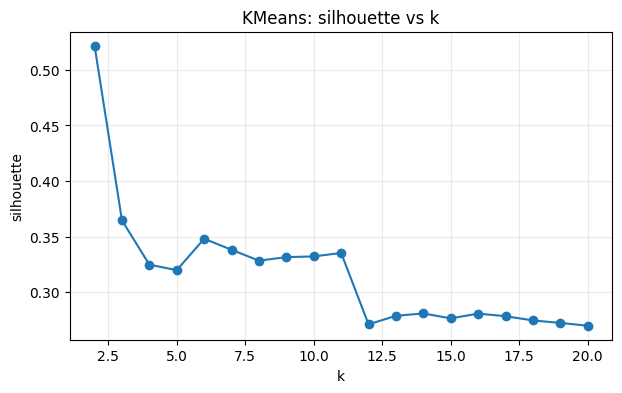

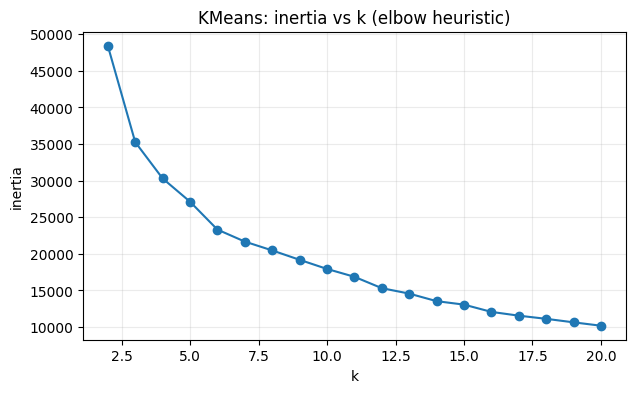

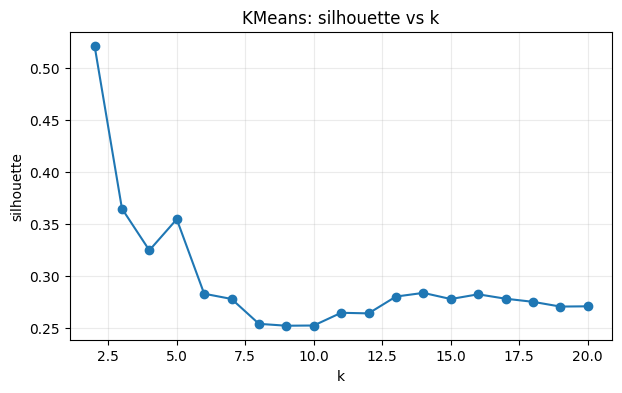

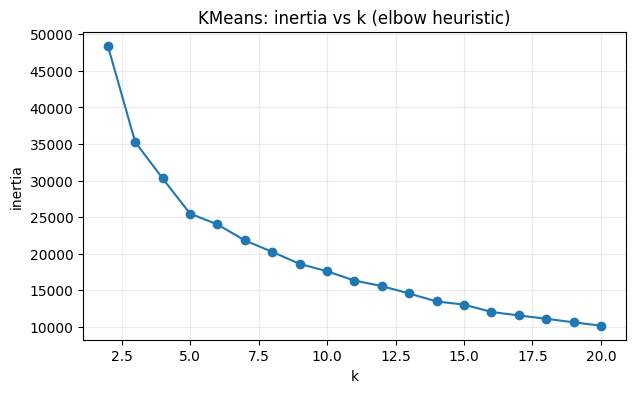

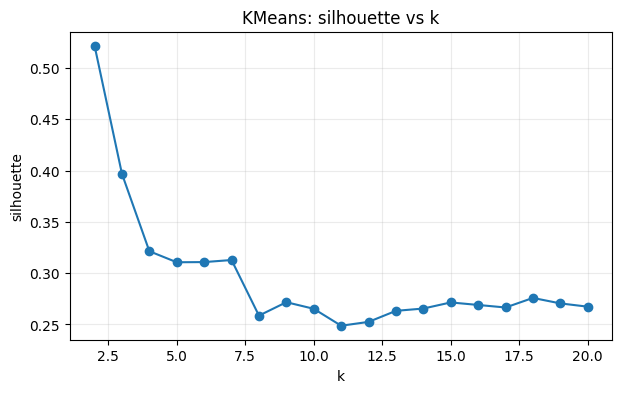

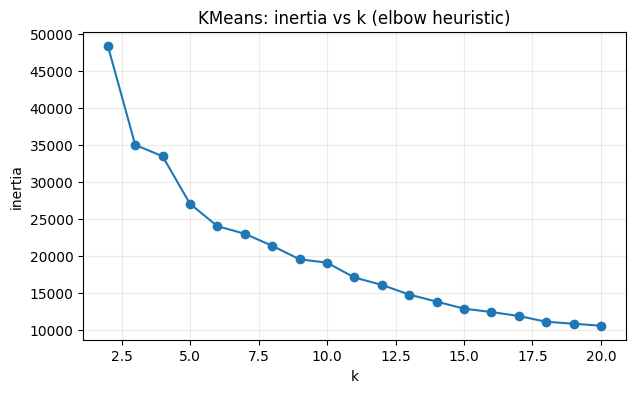

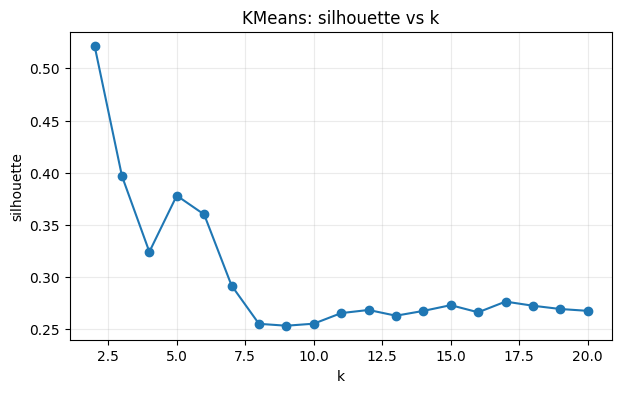

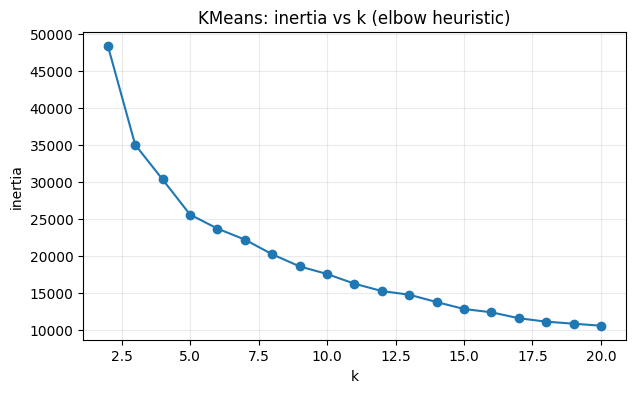

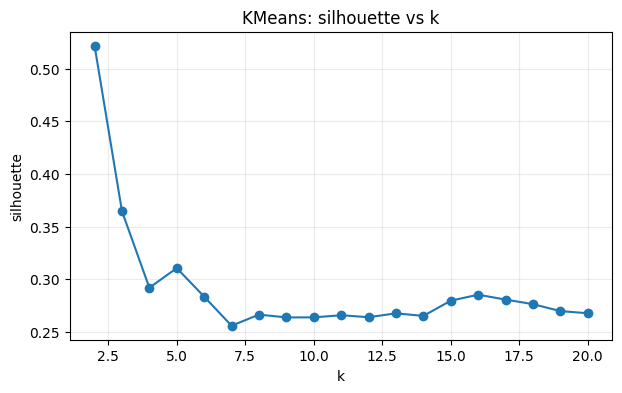

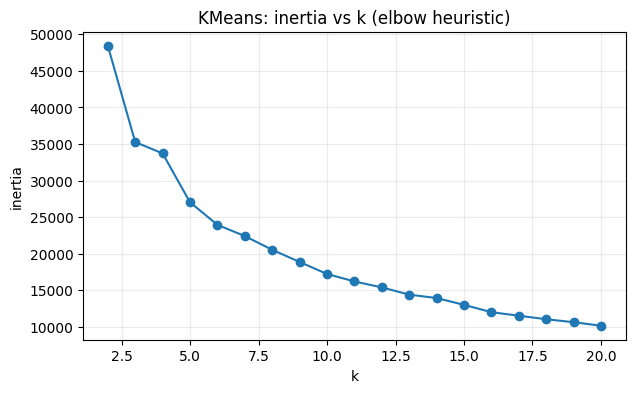

In [135]:
random_states = [123,2026,0,999,42]
kmean_results_dict={}

for random_state in random_states:
    RANDOM_STATE = random_state
    kmean_results_dict[RANDOM_STATE] = eval_kmeans_grid(X_feat,kmeans_ks,None)

    

Считаем среднее ARI чтобы понять результат

In [136]:
all_labels = []

for seed, algo_list in kmean_results_dict.items():
    for result in algo_list:
        all_labels.append(result['labels'])

n = len(all_labels)
ari_values = []

for i in range(n):
    for j in range(i+1, n): 
        ari = adjusted_rand_score(all_labels[i], all_labels[j])
        ari_values.append(ari)

mean_ari = np.mean(ari_values) if ari_values else 0

print(f"Среднее ARI: {mean_ari:.4f}")

Среднее ARI: 0.4678


По среднему результату ARI между перебранными результатами с разными random_state могу сделать вывод, что результаты умеренно схожи, но, видимо, инициализации не идеальны

Возвращаем random state в обычный вид

In [137]:
RANDOM_STATE=42

## Dataset 02

Делаем все аналогичные действия с первым датасетом

In [138]:
dataset_02 = pd.read_csv("data/S07-hw-dataset-02.csv")

dataset_02.head(5)

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [139]:
dataset_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [140]:
dataset_02.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [141]:
X = dataset_02.drop("sample_id",axis=1)
sample_id = dataset_02["sample_id"]

print("X.shape:", X.shape)

X.shape: (8000, 3)


In [142]:
X_feat = Preprocessing(X)

Числовых признаков: 3
Категориальных признаков: 0
X_feat.shape: (8000, 3)


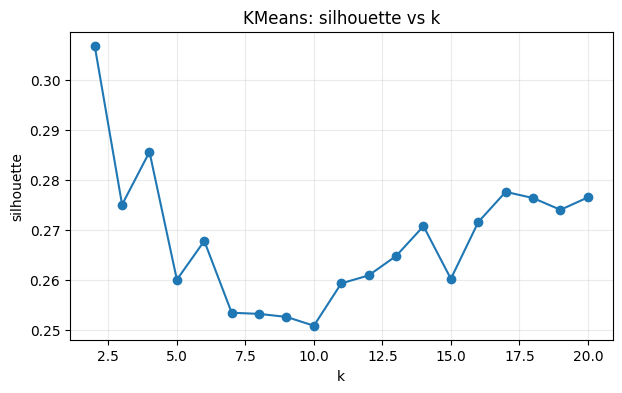

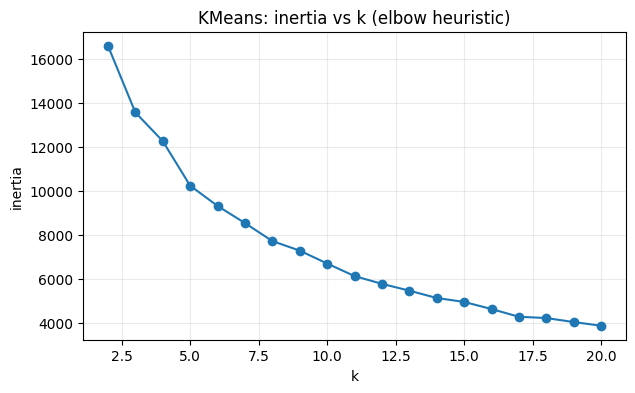

(19, {'k': 2}, {'k': 20})

In [143]:
kmeans_results = eval_kmeans_grid(X_feat,kmeans_ks,"ds02")
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

In [144]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)

({'k': 2}, 0.307)

In [145]:
dbscan_results,best_dbscan = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

Valid DBSCAN configs: 0
No valid config found


15

In [146]:
print_result_card_by_best(best_kmeans,best_dbscan)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.307
  davies_bouldin: 1.323
  calinski_harabasz: 3573.4
  inertia: 16588.5


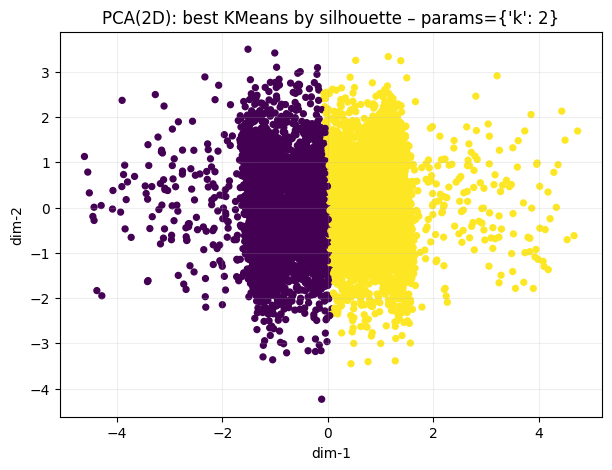

In [147]:
X_plot_2d(X_feat,best_kmeans,best_dbscan,"ds02")

In [148]:
metrics_summary["dataset_02"] = create_metrics_summary(best_kmeans,best_dbscan)

Вывод: Так-как не нашлось конфигов для DBSCAN с данным набором данных лучшая модель вышла KMeans

По результатам с этими данными получились четкие два кластера. DBSCAN с этой задачей не справился, не нашлось нужных конфигов. Сложности с данными не возникло - выбросов нет, данные полностью числовые, пропуски отсутствуют. Сложностей с задачей не возникло

In [149]:
best_configs["best_config_ds02"] = create_best_configs(best_kmeans)

In [150]:
label = pd.DataFrame()
label["sample_id"] = sample_id
label["cluster_label"] = best_kmeans["labels"]
label.to_csv(artifacts_path/"labels"/ 'labels_hw07_ds2.csv', index=False)

In [151]:
cluster_interpretation(X_feat,label,best_kmeans)


Размеры кластеров:
Кластер 0: 4017 объектов (50.2%)
Кластер 1: 3983 объектов (49.8%)

Характерные признаки по кластерам:
Кластер 0: f00↑(0.7), f01↓(-0.7), f02↑(0.0)
Кластер 1: f00↓(-0.7), f01↑(0.7), f02↓(-0.0)


## Dataset 03

Делаем все аналогичные действия с первым датасетом

In [152]:
dataset_03 = pd.read_csv("data/S07-hw-dataset-03.csv")

dataset_03.head(5)

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [153]:
dataset_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [154]:
dataset_03.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [155]:
X = dataset_03.drop("sample_id",axis=1)
sample_id = dataset_03["sample_id"]

print("X.shape:", X.shape)

X.shape: (15000, 4)


In [156]:
X_feat = Preprocessing(X)

Числовых признаков: 4
Категориальных признаков: 0
X_feat.shape: (15000, 4)


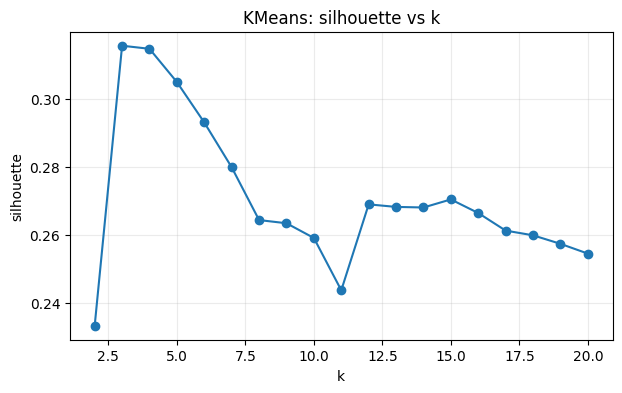

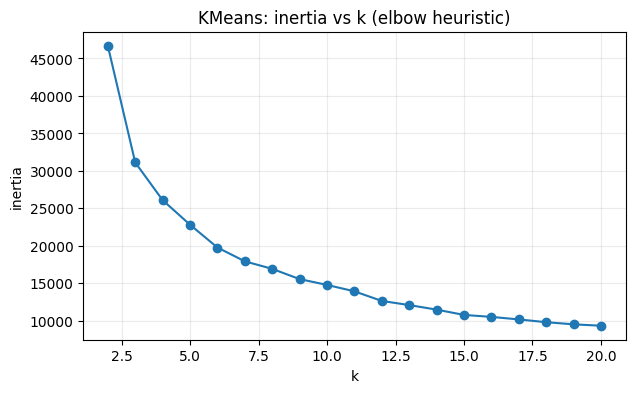

(19, {'k': 2}, {'k': 20})

In [157]:
kmeans_results = eval_kmeans_grid(X_feat,kmeans_ks,"ds03")
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

In [158]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)

({'k': 3}, 0.316)

In [159]:
dbscan_results,best_dbscan = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

Valid DBSCAN configs: 0
No valid config found


15

In [160]:
print_result_card_by_best(best_kmeans,best_dbscan)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 3}
n_clusters: 3
metrics:
  silhouette: 0.316
  davies_bouldin: 1.158
  calinski_harabasz: 6957.2
  inertia: 31123.5


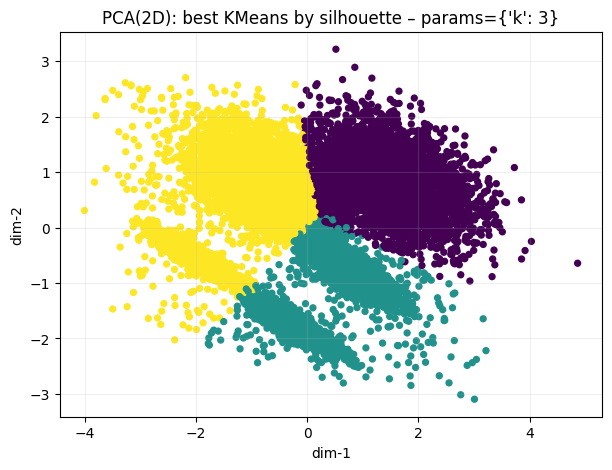

In [161]:
X_plot_2d(X_feat,best_kmeans,best_dbscan,"ds03")

In [162]:
metrics_summary["dataset_03"] = create_metrics_summary(best_kmeans,best_dbscan)

Вывод: Так-как не нашлось конфигов для DBSCAN с данным набором данных лучшая модель вышла KMeans

По результатам с этими данными получились четкие три кластера, DBSCAN не справился с данной задачей. Сложности с данными не возникло - выбросов нет, данные полностью числовые, пропуски отсутствуют. Сложностей с задачей не возникало

In [163]:
best_configs["best_config_ds03"] = create_best_configs(best_kmeans)

In [164]:
label = pd.DataFrame()
label["sample_id"] = sample_id
label["cluster_label"] = best_kmeans["labels"]
label.to_csv(artifacts_path/"labels"/ 'labels_hw07_ds3.csv', index=False)

In [165]:
cluster_interpretation(X_feat,label,best_kmeans)


Размеры кластеров:
Кластер 0: 3681 объектов (24.5%)
Кластер 1: 4903 объектов (32.7%)
Кластер 2: 6416 объектов (42.8%)

Характерные признаки по кластерам:
Кластер 0: f00↑(1.2), f01↑(1.0), f02↑(0.6)
Кластер 1: f01↓(-1.0), f02↑(0.7), f00↑(0.3)
Кластер 2: f02↓(-0.9), f00↓(-0.9), f01↑(0.2)


## Dataset 04

Делаем все аналогичные действия с первым датасетом

In [166]:
dataset_04 = pd.read_csv("data/S07-hw-dataset-04.csv")

dataset_04.head(5)

,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


In [167]:
dataset_04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

In [168]:
dataset_04.describe()

,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [169]:
X = dataset_04.drop("sample_id",axis=1)
sample_id = dataset_04["sample_id"]

print("X.shape:", X.shape)

X.shape: (10000, 32)


In [170]:
X_feat = Preprocessing(X)

Числовых признаков: 30
Категориальных признаков: 2
X_feat.shape: (10000, 42)


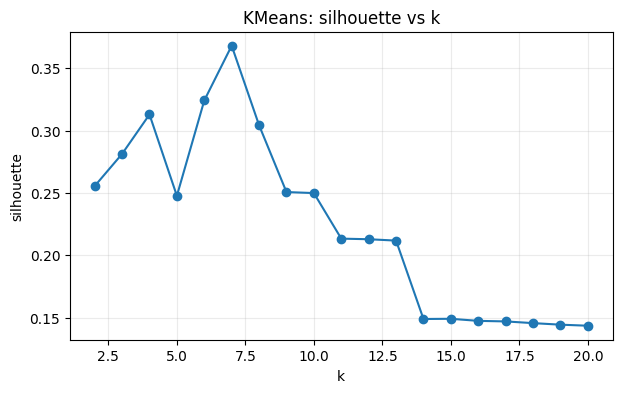

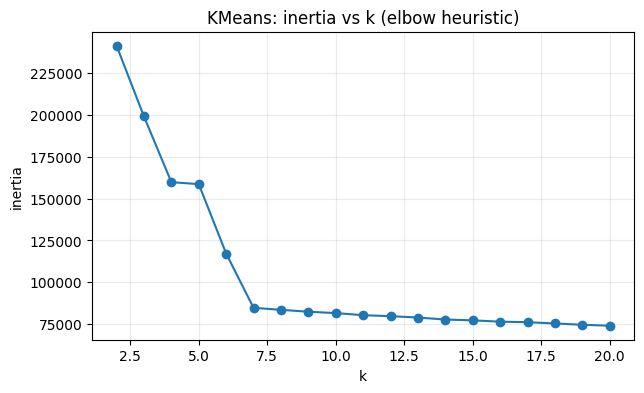

(19, {'k': 2}, {'k': 20})

In [171]:
kmeans_results = eval_kmeans_grid(X_feat,kmeans_ks,"ds04")
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

In [172]:
best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)

({'k': 7}, 0.368)

In [173]:
dbscan_results,best_dbscan = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)

Valid DBSCAN configs: 15
{'eps': 2.0, 'min_samples': 10} sil= 0.507 noise= 0.488 clusters= 6
{'eps': 3.5, 'min_samples': 3} sil= 0.447 noise= 0.0 clusters= 5
{'eps': 3.5, 'min_samples': 5} sil= 0.447 noise= 0.0 clusters= 5
{'eps': 3.5, 'min_samples': 10} sil= 0.447 noise= 0.0 clusters= 5
{'eps': 2.5, 'min_samples': 10} sil= 0.445 noise= 0.101 clusters= 6
{'eps': 2.5, 'min_samples': 5} sil= 0.442 noise= 0.088 clusters= 6
{'eps': 1.5, 'min_samples': 5} sil= 0.431 noise= 0.853 clusters= 22
{'eps': 3.0, 'min_samples': 10} sil= 0.426 noise= 0.009 clusters= 6
{'eps': 2.0, 'min_samples': 10}


15

In [174]:
print_result_card_by_best(best_kmeans,best_dbscan)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 7}
n_clusters: 7
metrics:
  silhouette: 0.368
  davies_bouldin: 1.711
  calinski_harabasz: 4558.9
  inertia: 84732.8
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 10}
n_clusters: 6
noise_frac: 0.488  non-noise: 5115
metrics:
  silhouette: 0.507
  davies_bouldin: 0.824
  calinski_harabasz: 3916.5


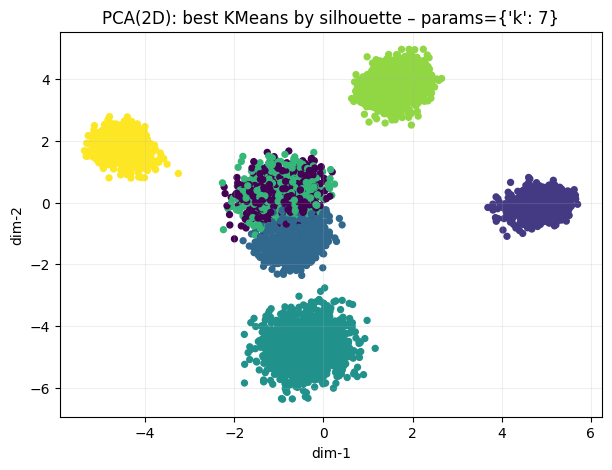

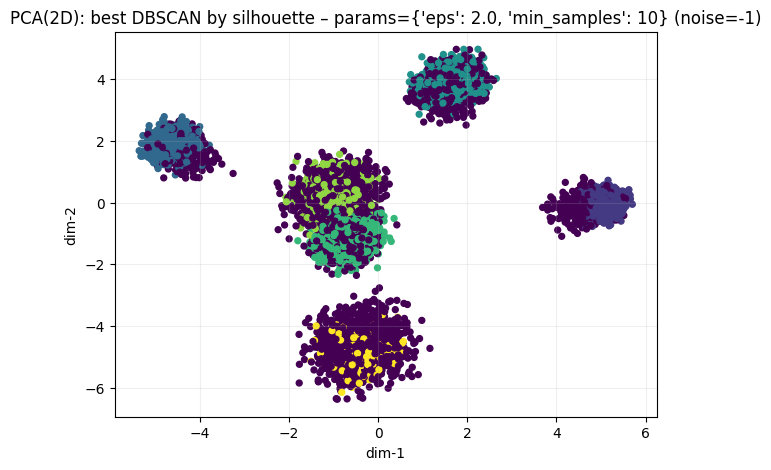

In [175]:
X_plot_2d(X_feat,best_kmeans,best_dbscan,"ds04")

In [176]:
metrics_summary["dataset_04"] = create_metrics_summary(best_kmeans,best_dbscan)

Вывод: По полученным метрикам DBSCAN показал себя получше, но он теряет почти половину данных (говорит что это шум). Так как нам лучше кластеризировать все точки, скажу что лучшая модель с таким набором данных это Kmeans

Два алгоритма довольно конфкликтно между собой справились с задачей. Сложности с данными не возникло - но есть пропуски и не числовые данные - препроцессинг спасает. DBSCAN дал странный результат с шумом, выкинув почти половину данных, но выдав результат на один кластер меньше.

In [177]:
best_configs["best_config_ds04"] = create_best_configs(best_kmeans)

In [178]:
label = pd.DataFrame()
label["sample_id"] = sample_id
label["cluster_label"] = best_kmeans["labels"]
label.to_csv(artifacts_path/"labels"/ 'labels_hw07_ds4.csv', index=False)

In [179]:
cluster_interpretation(X_feat,label,best_kmeans)


Размеры кластеров:
Кластер 0: 810 объектов (8.1%)
Кластер 1: 1667 объектов (16.7%)
Кластер 2: 1667 объектов (16.7%)
Кластер 3: 1666 объектов (16.7%)
Кластер 4: 857 объектов (8.6%)
Кластер 5: 1667 объектов (16.7%)
Кластер 6: 1666 объектов (16.7%)

Характерные признаки по кластерам:
Кластер 0: f31↑(1.8), f39↑(1.7), f21↓(-1.7)
Кластер 1: f04↓(-1.9), f32↑(1.8), f22↑(1.8)
Кластер 2: f33↑(1.8), f41↑(1.7), f18↓(-1.1)
Кластер 3: f19↓(-1.8), f35↑(1.8), f15↑(1.8)
Кластер 4: f31↑(1.8), f21↓(-1.6), f39↑(1.6)
Кластер 5: f09↓(-1.9), f30↑(1.8), f23↑(1.8)
Кластер 6: f01↑(2.0), f08↓(-1.9), f34↑(1.8)


## Сохранение результатов

Выводим все получившиеся метрики

In [180]:
metrics_summary

{'dataset_01': {'KMeans': {'silhouette': 0.5216395622404242,
   'davies_bouldin': 0.6853295219054459,
   'calinski_harabasz': 11786.95462267153},
  'DBSCAN': {'silhouette': 0.5216395622404242,
   'davies_bouldin': 0.6853295219054459,
   'calinski_harabasz': 11786.95462267153,
   'noise_frac': 0.0,
   'n_non_noise': 12000}},
 'dataset_02': {'KMeans': {'silhouette': 0.3068610017701601,
   'davies_bouldin': 1.3234721699867644,
   'calinski_harabasz': 3573.3933329348392}},
 'dataset_03': {'KMeans': {'silhouette': 0.31553248183109267,
   'davies_bouldin': 1.1577832240211114,
   'calinski_harabasz': 6957.158106946778}},
 'dataset_04': {'KMeans': {'silhouette': 0.36805814125837505,
   'davies_bouldin': 1.7108228373873862,
   'calinski_harabasz': 4558.868099573835},
  'DBSCAN': {'silhouette': 0.507439052565806,
   'davies_bouldin': 0.8240137635962008,
   'calinski_harabasz': 3916.495107696841,
   'noise_frac': 0.4885,
   'n_non_noise': 5115}}}

Выводим лучшие конфиги

In [181]:
best_configs

{'best_config_ds01': {'algo': 'kmeans',
  'params': {'k': 2},
  'criteria': 'metrics'},
 'best_config_ds02': {'algo': 'kmeans',
  'params': {'k': 2},
  'criteria': 'metrics'},
 'best_config_ds03': {'algo': 'kmeans',
  'params': {'k': 3},
  'criteria': 'metrics'},
 'best_config_ds04': {'algo': 'kmeans',
  'params': {'k': 7},
  'criteria': 'metrics'}}

Сохраняем артефакты в файлы

In [182]:
save_json(metrics_summary, artifacts_path/"metrics_summary.json")

save_json(best_configs, artifacts_path/"best_configs.json")